## 一、导入相关库

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']="SimHei"
from PIL import Image
import itertools
import os
from sklearn.tree import DecisionTreeClassifier#决策树
from sklearn.neighbors import KNeighborsClassifier#knn
from sklearn.neural_network import MLPClassifier #神经网络
from sklearn.naive_bayes import GaussianNB #朴素贝叶斯
from sklearn.svm import SVC#支持向量机
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc  #
# 绘制混淆矩阵函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#忽略警告
import warnings
warnings.filterwarnings('ignore')

## 二、数据预处理

* 设置三阶矩阵计算方法

In [74]:
def martix3(rd):
    temp=(np.mean(rd-rd.mean())**3)
    return np.sign(temp)*abs(temp)**(1/3)

* 切分图片、计算颜色矩(r、g、b分别对应的三阶矩)

In [78]:
path='images/'
images=os.listdir(path)
def transform(images):
    Level=[]#水质类别
    No=[]#每类对应序号
    R1=[]#R通道一阶矩
    R2=[]#R通道二阶矩
    R3=[]#R通道三阶矩
    G1=[]#G通道一阶矩
    G2=[]#G通道二阶矩
    G3=[]#G通道三阶矩
    B1=[]#B通道一阶矩
    B2=[]#B通道二阶矩
    B3=[]#B通道三阶矩
    for image in images:
        level=image.split('_')[0]#获取水质类别名称
        no=image.split('_')[1].split('.')[0]#获取每种类别的序号
        Level.append(level)
    #     No.append(no)

        #预处理图片
        img=Image.open(path+image)
        M,N=img.size
        region=img.crop((M/2-50,N/2-50,M/2+50,N/2+50))#截取中间图像
        r,g,b=region.split()#获取r,g,b通道
        #求一阶矩
        R1.append(np.array(r).mean())
        G1.append(np.array(g).mean())    
        B1.append(np.array(b).mean())
        #求二阶矩
        R2.append(np.array(r).std())
        G2.append(np.array(g).std())    
        B2.append(np.array(b).std())
        #求三阶矩
        R3.append(martix3(np.array(r)))
        G3.append(martix3(np.array(g)))
        B3.append(martix3(np.array(b)))
    data=pd.DataFrame({
        "水质类别":Level,
    #     "序号":No,
        "R通道一阶矩":R1,
        "G通道一阶矩":G1,
        "B通道一阶矩":B1,
        "R通道二阶矩":R2,
        "G通道二阶矩":G2,
        "B通道二阶矩":B2,
        "R通道三阶矩":R3,
        "G通道三阶矩":G3,
        "B通道三阶矩":B3
    })
    return data



#### 生成特征数据集，将数据与数据标签保存到本地

In [91]:
data=transform(images)
data

,水质类别,R通道一阶矩,G通道一阶矩,B通道一阶矩,R通道二阶矩,G通道二阶矩,B通道二阶矩,R通道三阶矩,G通道三阶矩,B通道三阶矩
0,1,148.6037,138.6396,64.3687,3.633077,4.128330,10.499046,-3.456080e-15,-1.455192e-15,-2.910383e-15
1,1,163.6769,145.5470,54.4608,3.934350,2.840174,3.502551,1.082299e-14,2.955858e-15,1.000444e-15
2,1,153.9430,147.0834,71.9601,2.225657,1.810979,3.136608,-1.205080e-14,-1.168701e-14,2.933120e-15
3,1,150.3724,151.3982,64.3164,2.037380,1.521590,2.728093,1.045919e-15,-2.773959e-15,-1.568878e-15
4,1,150.7381,150.9774,64.6204,1.918674,1.665260,3.110901,-2.864908e-15,1.127773e-14,-3.615241e-15
...,...,...,...,...,...,...,...,...,...,...
198,5,75.9841,109.0093,24.9639,3.773784,3.148303,2.140373,2.000888e-15,3.910827e-15,1.136868e-15
199,5,104.3394,124.2105,45.4477,3.224811,2.480522,3.734363,2.273737e-15,3.865352e-15,2.455636e-15
200,5,112.5145,131.3936,49.8200,3.140985,2.184051,4.043093,1.818989e-15,7.821654e-15,-2.728484e-16
201,5,113.1293,134.1274,48.3622,3.368202,2.537039,4.021146,-6.366463e-16,5.593392e-15,-1.455192e-15


In [90]:
label=data['水质类别']
data=data[data.columns[1:]]
label.to_json("label.json")
data.to_json("data.json")

## 三、定义模型评估方法

In [80]:
# 绘制混淆矩阵函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# 模型性能评估
def model_performance_evaluation(model_name, test, pred):
    print(model_name,  '| 准确率: %.4f' % accuracy_score(test, pred))
    pred=pred.astype('float64')
    print(model_name,'| 均方误差: %.4f' % mean_squared_error(test, pred))
    print(model_name, '| R2-score: %.4f' % r2_score(test, pred))


## 四、模型训练+评估
   * 决策树、knn、朴素贝叶斯、支持向量机、神经网络

In [81]:


def train_model(label,data,model_name):
    '''
    data:训练数据
    model_name:模型名称
    model:sklearn模型
    '''
    y=label
    X=data
    #划分数据集
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
    param={}
    
    #搜索最优参数
    if model_name=='决策树':
        param = {'criterion':['gini','entropy'],
                 'max_depth':[i for i in range (1,50)],
                 'min_samples_leaf':[2,3,5,10],
                 'min_impurity_decrease':[0.1,0.2,0.5]
                }
        grid = GridSearchCV(DecisionTreeClassifier(),param_grid=param,cv=6)
    
    if model_name=='k近邻':
        param={'weights':['uniform','distance'],
               'n_neighbors':[i for i in range(1,11)],
               'p':[i for i in range(1,6)]
              }
        grid = GridSearchCV(KNeighborsClassifier(),param_grid=param,cv=6)
    
    if model_name=='朴素贝叶斯':
        grid=GaussianNB()
        
    if model_name=='支持向量机':
        param={
            'cache_size' : [100, 200, 400],
            'C': [1, 10, 100],
            'kernel' : ['rbf', 'linear'],
            'degree' : [1, 2, 3, 4],
            }
        grid=GridSearchCV(SVC(),param_grid=param,cv=6)
        
    if model_name=='神经网络':
        param={
            'activation':['identity', 'logistic', 'tanh', 'relu'],
            'alpha':[10.0 ** ~ np.arange(1,7).any()],
            'hidden_layer_sizes': [(100,),(50,)],
            'max_iter': [1000,500,200,100]
        }
        grid=GridSearchCV(MLPClassifier(),param_grid=param,cv=6)
        
    #模型训练
    clf=grid
    model=clf.fit(X_train,y_train)
    #模型评估
    y_pred=model.predict(X_test)
    
    print(model_name+"在训练集上的性能 -- ")
    model_performance_evaluation(model_name, y_train, clf.predict(X_train))
    print("=========================================")
    print(model_name+"在测试集上的性能 -- ")
    model_performance_evaluation(model_name, y_test, y_pred)
    
    # 绘制混淆矩阵
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)  # 设置打印数量的阈值
    class_names = [1,2,3,4,5]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


决策树在训练集上的性能 -- 
决策树 | 准确率: 0.9012
决策树 | 均方误差: 0.1914
决策树 | R2-score: 0.8389
决策树在测试集上的性能 -- 
决策树 | 准确率: 0.9268
决策树 | 均方误差: 0.5122
决策树 | R2-score: 0.5141


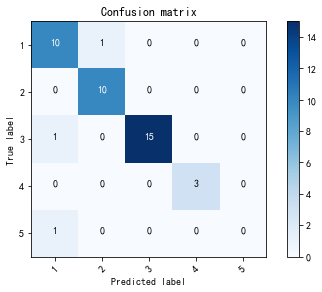

In [82]:
train_model(label,data,"决策树")

k近邻在训练集上的性能 -- 
k近邻 | 准确率: 1.0000
k近邻 | 均方误差: 0.0000
k近邻 | R2-score: 1.0000
k近邻在测试集上的性能 -- 
k近邻 | 准确率: 0.9512
k近邻 | 均方误差: 0.2439
k近邻 | R2-score: 0.7686


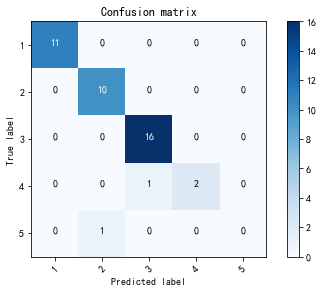

In [83]:
train_model(label,data,"k近邻")

朴素贝叶斯在训练集上的性能 -- 
朴素贝叶斯 | 准确率: 0.8395
朴素贝叶斯 | 均方误差: 0.2531
朴素贝叶斯 | R2-score: 0.7870
朴素贝叶斯在测试集上的性能 -- 
朴素贝叶斯 | 准确率: 0.8049
朴素贝叶斯 | 均方误差: 0.3902
朴素贝叶斯 | R2-score: 0.6298


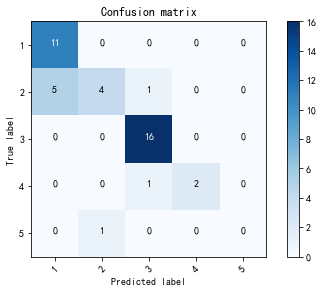

In [84]:
train_model(label,data,"朴素贝叶斯")

支持向量机在训练集上的性能 -- 
支持向量机 | 准确率: 1.0000
支持向量机 | 均方误差: 0.0000
支持向量机 | R2-score: 1.0000
支持向量机在测试集上的性能 -- 
支持向量机 | 准确率: 0.9756
支持向量机 | 均方误差: 0.2195
支持向量机 | R2-score: 0.7918


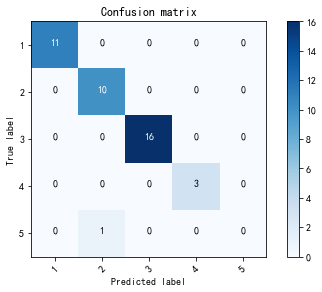

In [85]:
train_model(label,data,"支持向量机")

神经网络在训练集上的性能 -- 
神经网络 | 准确率: 0.8580
神经网络 | 均方误差: 0.4198
神经网络 | R2-score: 0.6467
神经网络在测试集上的性能 -- 
神经网络 | 准确率: 0.8049
神经网络 | 均方误差: 0.6829
神经网络 | R2-score: 0.3521


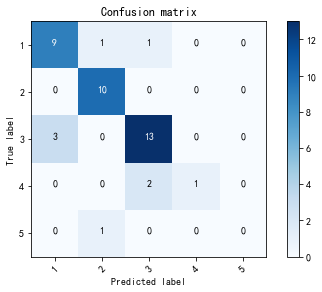

In [86]:
train_model(label,data,"神经网络")